In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import csv
import os
import numpy as np
from numpy import array
#from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense , Dropout, Activation, Permute, Multiply,SimpleRNN
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Input
from keras.layers import dot, concatenate
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
#from keras.layers import Bidirectional
#from keras import regularizers
#from keras.callbacks import ModelCheckpoint
#import tensorflow as tf
from keras.callbacks import TensorBoard
#from attention_decoder import AttentionDecoder
from keras import backend as K


# Preprocessing

In [3]:
def load_dataset(file):
    data=[]
    with open (file) as read:
        reader=csv.reader(read)
        for row in reader:
            data.append(row)
    data=np.array(data)
    data=data[:,-2:]
    return data
def split_train_test(data):
    num_sample=int(0.8*len(data))
    train, test=data[:num_sample], data[num_sample:]
    return train, test

def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_sequences(tokenizer, length, lines):
    # intereply encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y


In [4]:
#load dataset
dataset=load_dataset('cleaning_data.csv')
dataset=dataset[:3000]
token_dataset=dataset.reshape(-1,1)#dataset to tokenize
train, test=split_train_test(dataset)


In [5]:
#tokenizing
tokenizer=create_tokenizer(token_dataset[:,0])
wordindex=tokenizer.word_index
len_vocab=len(wordindex)+1
max_length=max(len(i.split()) for i in token_dataset[:,0])


In [6]:
# prepare training data
trainX = encode_sequences(tokenizer, max_length, train[:, 0])
trainY = encode_sequences(tokenizer, max_length, train[:, 1])
trainY = encode_output(trainY, len_vocab)


In [7]:
trainX.shape

(2400, 20)

In [8]:
# prepare validation data
testX = encode_sequences(tokenizer, max_length, test[:, 0])
testY = encode_sequences(tokenizer, max_length, test[:, 1])
testY = encode_output(testY, len_vocab)

# Define Model

In [9]:
# define NMT model
def define_model_rnn(vocab, timesteps, n_units):
    model = Sequential()
    model.add(Embedding(vocab, n_units, input_length=timesteps, mask_zero=True))
    #model.add(Embedding(vocab, n_units, weights=[embedding_vectors], input_length=timesteps, trainable=False))
    model.add(SimpleRNN(n_units, return_sequences=False))
    model.add(RepeatVector(timesteps))
    model.add(SimpleRNN(n_units, return_sequences=True))
    model.add(SimpleRNN(n_units, return_sequences=True))
    #model.add(BatchNormalization())
    
    model.add(TimeDistributed(Dense(vocab, activation='tanh',
                                        #kernel_regularizer=regularizers.l2(0.01),
                                        #activity_regularizer=regularizers.l2(0.01)
                                        )))
    return model

def define_model_lstm_gru(vocab, timesteps, n_units):
    model = Sequential()
    model.add(Embedding(vocab, n_units, input_length=timesteps, mask_zero=True))
    model.add(LSTM(n_units, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))
    model.add(RepeatVector(timesteps))
    model.add(GRU(n_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(BatchNormalization())
    #model.add(AttentionDecoder(n_units, vocab))
    model.add(TimeDistributed(Dense(vocab, activation='softmax',
                                        #kernel_regularizer=regularizers.l2(0.01),
                                        #activity_regularizer=regularizers.l2(0.01)
                                        )))
    return model

def define_model_gru_gru(vocab, timesteps, n_units):
    model = Sequential()
    model.add(Embedding(vocab, n_units, input_length=timesteps, mask_zero=True))
    model.add(GRU(n_units, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))
    model.add(RepeatVector(timesteps))
    model.add(GRU(n_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(BatchNormalization())
    #model.add(AttentionDecoder(n_units, vocab))
    model.add(TimeDistributed(Dense(vocab, activation='softmax',
                                        #kernel_regularizer=regularizers.l2(0.01),
                                        #activity_regularizer=regularizers.l2(0.01)
                                        )))
    return model

def define_model_gru_lstm(vocab, timesteps, n_units):
    model = Sequential()
    model.add(Embedding(vocab, n_units, input_length=timesteps, mask_zero=True))
    model.add(GRU(n_units, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))
    model.add(RepeatVector(timesteps))
    model.add(Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Bidirectional(LSTM(n_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(AttentionDecoder(n_units, vocab))
    model.add(TimeDistributed(Dense(vocab, activation='softmax',
                                        #kernel_regularizer=regularizers.l2(0.01),
                                        #activity_regularizer=regularizers.l2(0.01)
                                        )))
    return model

    

In [10]:
def encoder(input):
    decoder_input = np.zeros_like(input)
    decoder_input[:, 1:] = encoded_training_output[:,:-1]
    training_decoder_input[:, 0] = WORD_CODE_START
    training_decoder_output = np.eye(dict_size)[encoded_training_output.astype('int')]

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1(y_true, y_pred):
    result_precision = precision(y_true, y_pred)
    result_recall = recall(y_true, y_pred)
    return 2*((result_precision*result_recall)/(result_precision+result_recall+K.epsilon()))

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'rb')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def score(model):
    import timeit
    start_time = timeit.default_timer()
    score = model.evaluate(testX, testY, batch_size=64)
    print(timeit.default_timer() - start_time)
    return score

    

In [11]:
tensor_board = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

**Model**

In [12]:
def summary(model):
    _model = model(len(wordindex)+1, max_length, 256)
    _model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', precision, recall, f1])
    print('=========={}==========='.format(_model))
    return print(_model.summary())
    

==============<function define_model_rnn at 0x000001E0B9ADC550>===========
Epoch 1/100
38/38 [==============================] - 15s 303ms/step - loss: 13.0719 - accuracy: 0.2140 - precision: 0.0392 - recall: 0.2730 - f1: 0.0427 - val_loss: 12.5921 - val_accuracy: 0.2396 - val_precision: 6.6085e-04 - val_recall: 0.3722 - val_f1: 0.0013
Epoch 2/100
38/38 [==============================] - 11s 285ms/step - loss: 11.4054 - accuracy: 0.2435 - precision: 6.9127e-04 - recall: 0.3705 - f1: 0.0014 - val_loss: 6.5635 - val_accuracy: 0.0968 - val_precision: 4.2475e-04 - val_recall: 0.1557 - val_f1: 8.4718e-04
Epoch 3/100
38/38 [==============================] - 11s 302ms/step - loss: 13.9425 - accuracy: 0.1797 - precision: 1.9389e-04 - recall: 0.3269 - f1: 3.8749e-04 - val_loss: 13.6019 - val_accuracy: 0.2855 - val_precision: 2.8784e-04 - val_recall: 0.4531 - val_f1: 5.7532e-04
Epoch 4/100
38/38 [==============================] - 11s 289ms/step - loss: 13.5050 - accuracy: 0.2953 - precision: 2.98

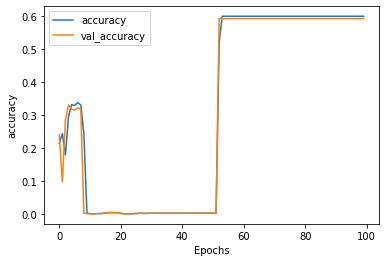

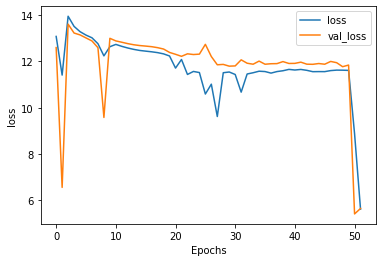

10/10 [==============================] - 1s 89ms/step - loss: nan - accuracy: 0.5925 - precision: nan - recall: nan - f1: nan
0.9452617999631912
10/10 [==============================] - 1s 88ms/step - loss: nan - accuracy: 0.5925 - precision: nan - recall: nan - f1: nan
0.9603742000181228
[nan, 0.5924999713897705, nan, nan, nan]
==============<function define_model_lstm_gru at 0x000001E0B9ADDEA0>===========
Epoch 1/100
38/38 [==============================] - 30s 568ms/step - loss: 5.6156 - accuracy: 0.4471 - precision: 0.5534 - recall: 0.1525 - f1: 0.2174 - val_loss: 4.8897 - val_accuracy: 0.5995 - val_precision: 0.7237 - val_recall: 0.5825 - val_f1: 0.6455
Epoch 2/100
38/38 [==============================] - 20s 526ms/step - loss: 3.5152 - accuracy: 0.6009 - precision: 0.8134 - recall: 0.5295 - f1: 0.6410 - val_loss: 5.2883 - val_accuracy: 0.5993 - val_precision: 0.6931 - val_recall: 0.5895 - val_f1: 0.6371
Epoch 3/100
38/38 [==============================] - 21s 549ms/step - loss: 3

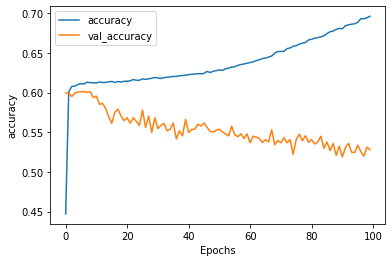

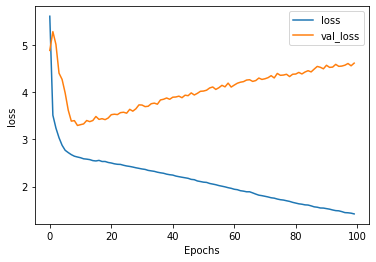

10/10 [==============================] - 1s 136ms/step - loss: 4.6199 - accuracy: 0.5281 - precision: 0.7685 - recall: 0.4706 - f1: 0.5835
1.4647792999166995
10/10 [==============================] - 1s 146ms/step - loss: 4.6199 - accuracy: 0.5281 - precision: 0.7685 - recall: 0.4706 - f1: 0.5835
1.5448096001055092
[4.619913578033447, 0.528083324432373, 0.7684646844863892, 0.4705989956855774, 0.5835120677947998]
==============<function define_model_gru_gru at 0x000001E0C85A9AB0>===========
Epoch 1/100
38/38 [==============================] - 28s 577ms/step - loss: 5.5665 - accuracy: 0.4492 - precision: 0.5311 - recall: 0.1573 - f1: 0.2201 - val_loss: 4.9015 - val_accuracy: 0.5974 - val_precision: 0.7257 - val_recall: 0.5819 - val_f1: 0.6459
Epoch 2/100
38/38 [==============================] - 21s 545ms/step - loss: 3.5127 - accuracy: 0.6013 - precision: 0.8056 - recall: 0.5389 - f1: 0.6456 - val_loss: 5.2890 - val_accuracy: 0.5993 - val_precision: 0.6921 - val_recall: 0.5894 - val_f1: 0

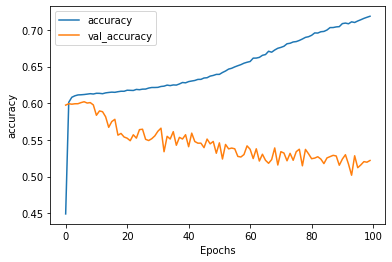

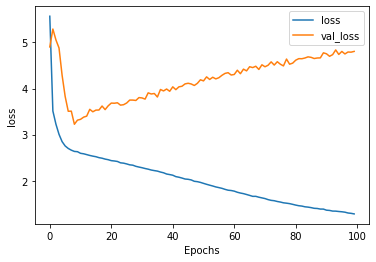

10/10 [==============================] - 1s 132ms/step - loss: 4.8043 - accuracy: 0.5220 - precision: 0.7438 - recall: 0.4647 - f1: 0.5717
1.4553074000868946
10/10 [==============================] - 1s 134ms/step - loss: 4.8043 - accuracy: 0.5220 - precision: 0.7438 - recall: 0.4647 - f1: 0.5717
1.435139900073409
[4.804278373718262, 0.5220000147819519, 0.7437963485717773, 0.46471357345581055, 0.5717281103134155]
==============<function define_model_gru_lstm at 0x000001E0C85A9BD0>===========
Epoch 1/100
38/38 [==============================] - 76s 1s/step - loss: 4.9941 - accuracy: 0.4464 - precision: 0.4753 - recall: 0.2324 - f1: 0.2982 - val_loss: 3.2151 - val_accuracy: 0.5925 - val_precision: 0.7629 - val_recall: 0.5641 - val_f1: 0.6486
Epoch 2/100
38/38 [==============================] - 57s 2s/step - loss: 2.8141 - accuracy: 0.6076 - precision: 0.8160 - recall: 0.5249 - f1: 0.6385 - val_loss: 3.1966 - val_accuracy: 0.5925 - val_precision: 0.7542 - val_recall: 0.5702 - val_f1: 0.649

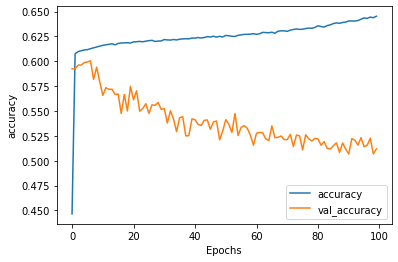

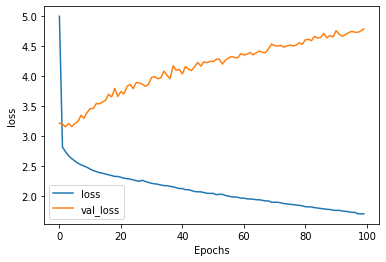

10/10 [==============================] - 3s 312ms/step - loss: 4.7818 - accuracy: 0.5118 - precision: 0.7899 - recall: 0.4553 - f1: 0.5773
3.942195200128481
10/10 [==============================] - 3s 308ms/step - loss: 4.7818 - accuracy: 0.5118 - precision: 0.7899 - recall: 0.4553 - f1: 0.5773
3.170379300136119
[4.781800746917725, 0.5118333101272583, 0.7898693084716797, 0.45528644323349, 0.5773375630378723]


In [14]:
def fitting(model):
    _model = model(len(wordindex)+1, max_length, 256)
    _model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', precision, recall, f1])
    history= _model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=1,callbacks=[tensor_board])
    return history,_model


model_func=[define_model_rnn,define_model_lstm_gru,define_model_gru_gru,define_model_gru_lstm]
model_name=['model_rnn','model_lstm_gru','model_gru_gru','model_gru_lstm']
score_model=[]
for i,model in enumerate(model_func):
    print('=============={}==========='. format(model))
    history, _model=fitting(model)
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    score_model.append(score(_model))
    print(score(_model))
    name=model_name[i]
    filename = 'Model/'+name+'.h5'
    _model.save(filename)
    
